# Imports


In [1]:
#%pip install h3
#%pip install tobler
#%pip install folium

In [2]:
import warnings
import h3
import ee
import google
import os
import folium

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tobler.util import h3fy
from shapely.wkt import loads

In [3]:
ee.Authenticate()

Enter verification code: 4/1AZEOvhU9DlJKcQ0PmnEr4_cNpcnQ6BNOYSaPwauFd52GP82gy2x_z_bAP98

Successfully saved authorization token.


In [4]:
ee.Initialize()

In [5]:
try:
  import ee_jupyter
except ModuleNotFoundError:
  print('ee_jupyter was not found. Installing now...')
  result = os.system('pip -q install earthengine-jupyter')
  import ee_jupyter
print(f'ee_jupyter (version {ee_jupyter.__version__}) '
        f'is installed.')

ee_jupyter (version 0.0.7) is installed.


In [6]:
from ee_jupyter.ipyleaflet import Map

In [7]:
warnings.filterwarnings('ignore')

# Import Temperature Data and Set Up Map

In [8]:
image_collection = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY")
image = image_collection.filterDate('2012-01-01', '2022-12-31').select('temperature_2m').mean().multiply(1.8).subtract(459.67)

In [9]:
image.min(image).getInfo()

{'type': 'Image',
 'bands': [{'id': 'temperature_2m',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [10]:
location_lonlat= [-134.424637, 58.301041]
map_init_params = {
    'center': list(reversed(location_lonlat)), # <lat,lon> ordering
    'zoom': 3
}
map1 = Map(**map_init_params)

In [11]:
map1.addLayer(
  image,
  {'min': -40, 'max': 26, 'palette': ['grey', 'blue']}, # remember temperature here is in Kelvin
  'air temperature ()'
)

# Census Tract (2020)

In [12]:
tracts_feature = ee.FeatureCollection("TIGER/2020/TRACT")
ak_tracts = tracts_feature.filter(ee.Filter.equals('STATEFP', '02'))

In [13]:
style = {'color': '0000ffff', 'width': 2, 'lineType': 'solid', 'fillColor': '00000080'}
map1.addLayer(ak_tracts.style(**style), {}, "Census Tracts")

In [14]:
reduced_temp_tract = image.reduceRegions(collection=ak_tracts, reducer=ee.Reducer.mean(), scale=11132, tileScale=1)

#reduced_temp_tract = kelvin_air_temp.reduceRegions(ak_tracts, ee.Reducer.mean())

In [15]:
reduced_temp_tract.aggregate_min("mean").getInfo()

16.383872156206625

In [16]:
reduced_temp_tract.aggregate_max("mean").getInfo()

45.35061339131511

In [17]:
tract_map = Map(**map_init_params)

empty = ee.Image().byte()
fills_tract = empty.paint(
  featureCollection = reduced_temp_tract,
  color = 'mean',
)
tract_map.addLayer(fills_tract, {'palette': ['white', 'red'], 'min': 16, 'max': 45}, 'mean temp by census tract')
tract_map

Map(center=[58.301041, -134.424637], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

# Census Boroughs (2018)

In [18]:
census_boroughs = ee.FeatureCollection("TIGER/2018/Counties")
ak_boroughs = census_boroughs.filter(ee.Filter.equals('STATEFP', '02'))

In [19]:
reduced_temp_borough = image.reduceRegions(collection=ak_boroughs, reducer=ee.Reducer.mean(), scale=11132, tileScale=1)

In [20]:
reduced_temp_borough.aggregate_min("mean").getInfo()

16.56192559582919

In [21]:
reduced_temp_borough.aggregate_max("mean").getInfo()

43.369943443120476

In [22]:
borough_map = Map(**map_init_params)

empty = ee.Image().byte()
fills_borough = empty.paint(
  featureCollection = reduced_temp_borough,
  color = 'mean',
)
borough_map.addLayer(fills_borough, {'palette': ['white', 'red'], 'min': 16, 'max': 44}, 'mean temp by borough')
borough_map

Map(center=[58.301041, -134.424637], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

# Census Block Groups (2020)

This is a little slower than the above calculations, but not too bad.

In [23]:
census_bg = ee.FeatureCollection("TIGER/2020/BG")
ak_bg = census_bg.filter(ee.Filter.equals('STATEFP', '02'))

In [24]:
reduced_temp_bg = image.reduceRegions(collection=ak_bg, reducer=ee.Reducer.mean(), scale=11132, tileScale=1)

In [25]:
reduced_temp_bg.aggregate_min("mean").getInfo()

15.967849405087462

In [26]:
reduced_temp_borough.aggregate_max("mean").getInfo()

43.369943443120476

In [27]:
bg_map = Map(**map_init_params)

empty = ee.Image().byte()
fills_bg = empty.paint(
  featureCollection = reduced_temp_bg,
  color = 'mean',
)
bg_map.addLayer(fills_bg, {'palette': ['white', 'red'], 'min': 15.967849405087462, 'max': 44}, 'mean temp by census block group')
bg_map

Map(center=[58.301041, -134.424637], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

# Hexagons!!

<AxesSubplot: >

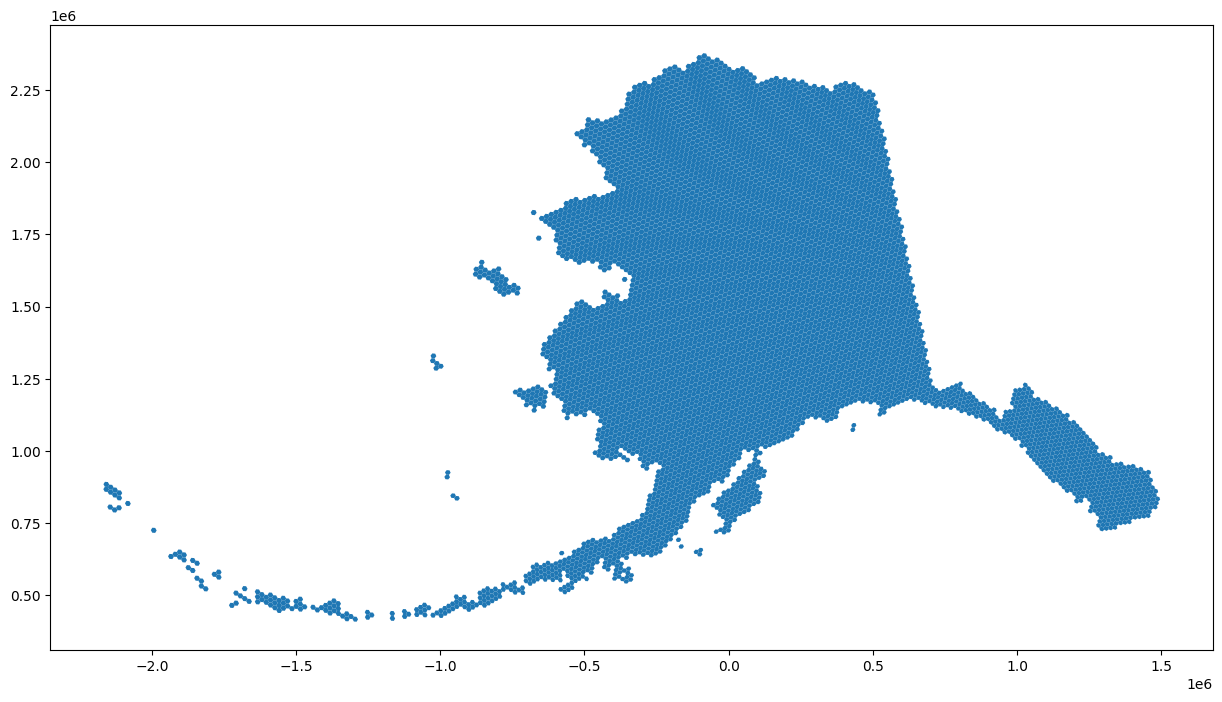

In [42]:
# get the following shape file from
# https://live.laborstats.alaska.gov/cen/maps/gis/Boroughs2020.zip
# hosted at
# https://live.laborstats.alaska.gov/cen/maps-gis

geodf = gpd.read_file('../Data/Boroughs2020/Boroughs2020.shp')
hexgrid_res5 = h3fy(geodf.buffer(0.01), resolution=5)
hexgrid_res5.plot(figsize=(15,15));

<AxesSubplot: >

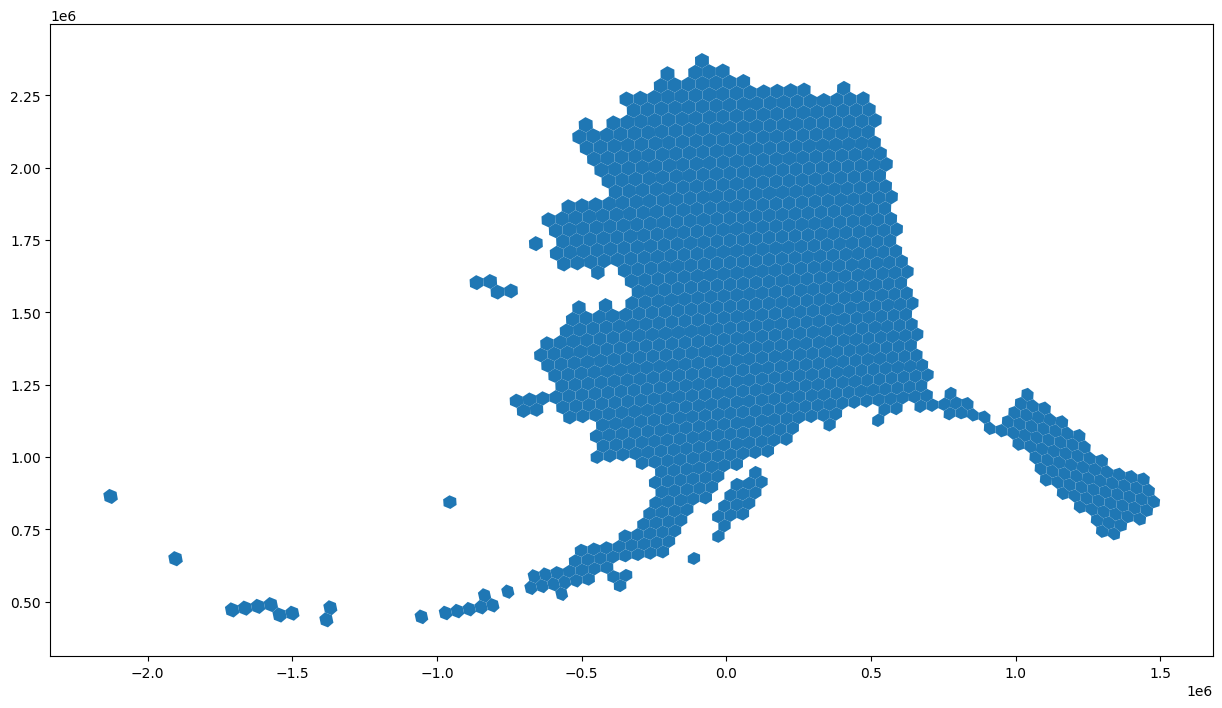

In [43]:
hexgrid_res4 = h3fy(geodf.buffer(0.01), resolution=4)
hexgrid_res4.plot(figsize=(15,15));

In [33]:
geodf = geodf.to_crs(4326)
hexgrid_res5_4326 = h3fy(geodf.buffer(0.01), resolution=5)
hexgrid_res4_4326 = h3fy(geodf.buffer(0.01), resolution=4)

In [34]:
def get_ee_feature(geom):
    x,y = geom.exterior.coords.xy
    coords = np.dstack((x,y)).tolist()
    g = ee.Geometry.Polygon(coords)
    return ee.Feature(g)
features5 = ee.FeatureCollection([get_ee_feature(x[1].geometry) for x in hexgrid_res5_4326.iterrows()])
features4 = ee.FeatureCollection([get_ee_feature(x[1].geometry) for x in hexgrid_res4_4326.iterrows()])

In [36]:
zone_stats4 = image.reduceRegions(collection=features4, reducer=ee.Reducer.mean(), scale=11132, tileScale=1).getInfo()
zone_stats4 = gpd.GeoDataFrame.from_features(zone_stats4, crs='epsg:4326')
zone_stats4_3338 = zone_stats4.to_crs(3338)


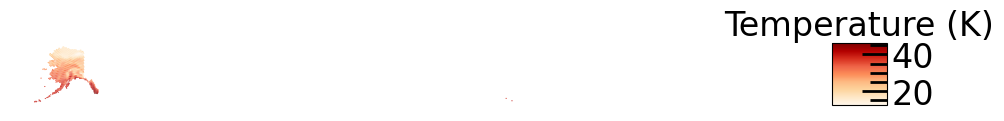

In [37]:
# the following plot is wacky due to CRS; Alaska crosses the international date line
fig, ax = plt.subplots(figsize=(15,15))

# Define the legend axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%",  pad=0.1)

# Plot the U.S. map with hexagons, where the colour represents the mean air temperature
zone_stats4.plot(column='mean', ax=ax, cmap='OrRd', legend=True, cax=cax)

# Customise the legend
cax.minorticks_on()
cax.tick_params(which='major', direction='in', length=18, width=2, labelsize=24)
cax.tick_params(which='minor', direction='in', length=12, width=2, labelsize=24)
cax.set_title('Temperature (K)', fontsize=24)

# Turn the x-axis and y-axis off
ax.set_axis_off()

In [38]:
zone_stats4_3338 = zone_stats4.to_crs(3338)

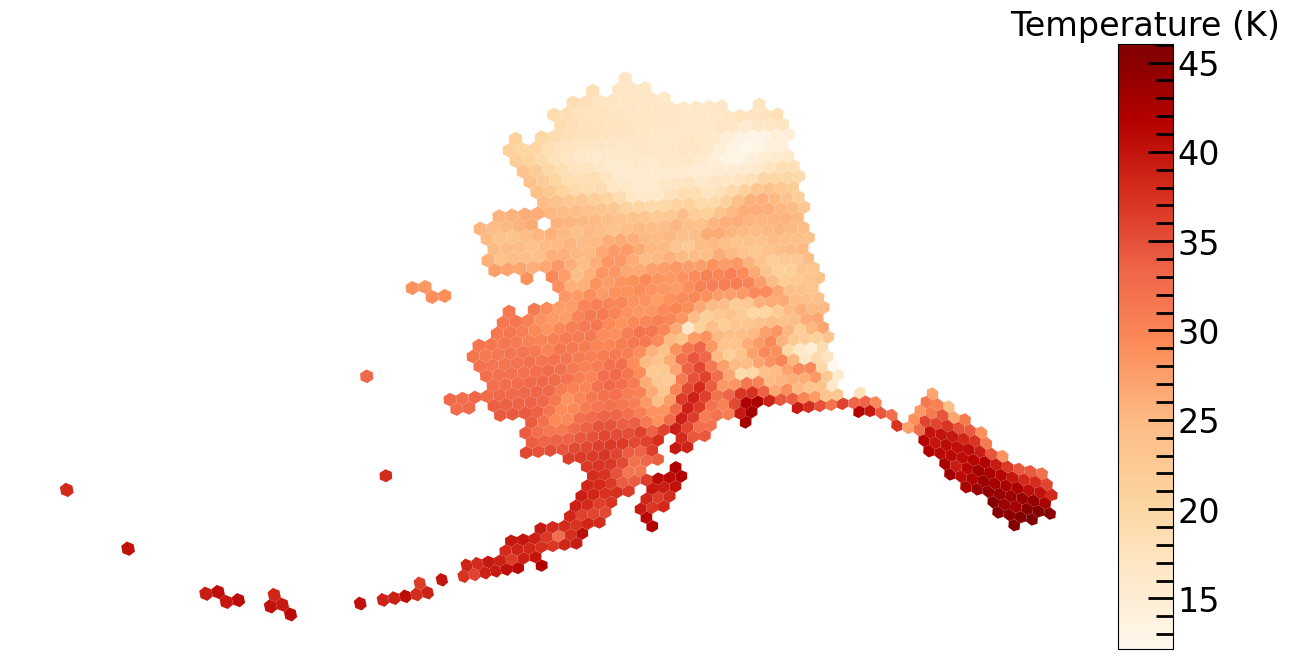

In [39]:
fig, ax = plt.subplots(figsize=(15,15))

# Define the legend axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%",  pad=0.1)

# Plot the U.S. map with hexagons, where the colour represents the mean air temperature
zone_stats4_3338.plot(column='mean', ax=ax, cmap='OrRd', legend=True, cax=cax)

# Customise the legend
cax.minorticks_on()
cax.tick_params(which='major', direction='in', length=18, width=2, labelsize=24)
cax.tick_params(which='minor', direction='in', length=12, width=2, labelsize=24)
cax.set_title('Temperature (K)', fontsize=24)

# Turn the x-axis and y-axis off
ax.set_axis_off()

In [41]:
temp_map = zone_stats4_3338.explore(column='mean', name='Mean Temperature', cmap='OrRd', 
                              style_kwds={'opacity':0.4, 'color':'black', 'opacity':0.2}, 
                              highlight_kwds={'fillOpacity':1}, 
                              tooltip_kwds={'aliases':['Temperature']}, 
                              legend_kwds={'caption':'Mean Temperature (F)'})

# Add layer control to the map
folium.TileLayer('cartodbdark_matter',overlay=True,name="View in Dark Mode").add_to(temp_map)
folium.TileLayer('cartodbpositron',overlay=True,name="View in Light Mode").add_to(temp_map)
folium.LayerControl(collapsed=False).add_to(temp_map)

temp_map